In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
origin = pd.read_csv('./WineQT.csv')

In [3]:
train = pd.concat([train,origin],axis=0).drop('Id',axis=1).drop_duplicates().reset_index(drop=True)
train = train.drop('pH',axis=1)
train = train.drop('free sulfur dioxide',axis=1)
train = train.drop('residual sugar',axis=1)
# train = train.drop('chlorides',axis=1)
train = train.drop('fixed acidity',axis=1)

In [4]:
test = test.drop('pH',axis=1)
test = test.drop('free sulfur dioxide',axis=1)
test = test.drop('residual sugar',axis=1)
# test = test.drop('chlorides',axis=1)
test = test.drop('fixed acidity',axis=1)

In [5]:
train.corr()

,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
volatile acidity,1.000000,-0.570177,0.042140,0.078616,-0.038568,-0.317440,-0.212796,-0.282514
citric acid,-0.570177,1.000000,0.185083,-0.040451,0.373818,0.293162,0.089312,0.173892
chlorides,0.042140,0.185083,1.000000,0.022236,0.216366,0.232797,-0.182042,-0.080917
total sulfur dioxide,0.078616,-0.040451,0.022236,1.000000,0.092531,-0.093736,-0.277965,-0.209408
density,-0.038568,0.373818,0.216366,0.092531,1.000000,0.051480,-0.408874,-0.162885
sulphates,-0.317440,0.293162,0.232797,-0.093736,0.051480,1.000000,0.188536,0.321986
alcohol,-0.212796,0.089312,-0.182042,-0.277965,-0.408874,0.188536,1.000000,0.481907
quality,-0.282514,0.173892,-0.080917,-0.209408,-0.162885,0.321986,0.481907,1.000000


In [6]:
train.quality.value_counts()

5    1272
6    1187
7     455
4      88
8      54
3      18
Name: quality, dtype: int64

In [7]:
# train = train[(train.quality > 4) & (train.quality < 8)]

In [8]:
train = train.reset_index(drop=True)

In [9]:
train['quality'] = [i-3 for i in train['quality']]

<AxesSubplot: ylabel='Frequency'>

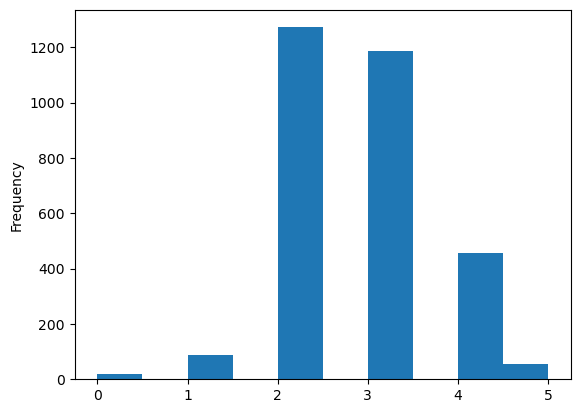

In [10]:
train.quality.plot.hist()

In [11]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()

In [12]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, f1_score, cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from category_encoders import LeaveOneOutEncoder

from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier, XGBRFRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

import optuna
from optuna.samplers import TPESampler

import warnings

warnings.filterwarnings('ignore')

C:\Users\user\anaconda3\envs\ml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [13]:
target = 'quality'
features = [c for c in train.columns if c not in [target]]

In [14]:
kf = StratifiedKFold(n_splits = 10, random_state = 41, shuffle = True)
models = []
val_scores = []
preds = []

params = {
'n_estimators':15000,
'max_depth':5,
'early_stopping_rounds':200,
'learning_rate':0.008,
'one_hot_max_size':3,
'bootstrap_type':"MVS",
'l2_leaf_reg':2,
'random_state':41
         }

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train, train[target]))):
    
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]
    
#     if include_orig:
#         X_train = X_train.append(original[features], ignore_index = True)
#         y_train = y_train.append(original[target], ignore_index = True)
    
    model = CatBoostClassifier(**params)
    
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 2000)
    
    models.append(model)
    # pred = model.predict_proba(X_val)[:,1]
    # score = accuracy_score(y_val, model.predict(X_val))
    score = cohen_kappa_score(y_val, model.predict(X_val), weights = 'quadratic')

    val_scores.append(score)
    
    print(f'ACC on fold {i}: {score:.4f}')
    
print(f'mean AUC across all folds: {np.mean(val_scores):.4f}')

0it [00:00, ?it/s]

0:	learn: 1.7794636	test: 1.7795273	best: 1.7795273 (0)	total: 146ms	remaining: 36m 28s


1it [00:03,  3.79s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9898773015
bestIteration = 1136

Shrink model to first 1137 iterations.
ACC on fold 0: 0.5100
0:	learn: 1.7790513	test: 1.7796512	best: 1.7796512 (0)	total: 2.79ms	remaining: 41.9s


2it [00:06,  2.94s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 1.058175523
bestIteration = 633

Shrink model to first 634 iterations.
ACC on fold 1: 0.4222
0:	learn: 1.7795966	test: 1.7797694	best: 1.7797694 (0)	total: 11.9ms	remaining: 2m 58s


3it [00:11,  3.88s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9619797681
bestIteration = 1572

Shrink model to first 1573 iterations.
ACC on fold 2: 0.5366
0:	learn: 1.7795392	test: 1.7798360	best: 1.7798360 (0)	total: 2.99ms	remaining: 44.9s


4it [00:14,  3.55s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9900417952
bestIteration = 870

Shrink model to first 871 iterations.
ACC on fold 3: 0.4938
0:	learn: 1.7790959	test: 1.7796847	best: 1.7796847 (0)	total: 4ms	remaining: 1m


5it [00:16,  3.28s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9855599699
bestIteration = 735

Shrink model to first 736 iterations.
ACC on fold 4: 0.4985
0:	learn: 1.7791926	test: 1.7791734	best: 1.7791734 (0)	total: 18.2ms	remaining: 4m 33s


6it [00:19,  3.03s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9987020044
bestIteration = 703

Shrink model to first 704 iterations.
ACC on fold 5: 0.5403
0:	learn: 1.7794913	test: 1.7796165	best: 1.7796165 (0)	total: 3.06ms	remaining: 45.9s


7it [00:23,  3.19s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9799844254
bestIteration = 1062

Shrink model to first 1063 iterations.
ACC on fold 6: 0.5349
0:	learn: 1.7792332	test: 1.7791267	best: 1.7791267 (0)	total: 2.9ms	remaining: 43.4s
2000:	learn: 0.8085904	test: 0.9416494	best: 0.9416382 (1993)	total: 5.24s	remaining: 34.1s


8it [00:29,  4.16s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9416021299
bestIteration = 2011

Shrink model to first 2012 iterations.
ACC on fold 7: 0.5295
0:	learn: 1.7791130	test: 1.7795697	best: 1.7795697 (0)	total: 2.91ms	remaining: 43.7s


9it [00:32,  4.01s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 1.005293646
bestIteration = 1085

Shrink model to first 1086 iterations.
ACC on fold 8: 0.4995
0:	learn: 1.7794215	test: 1.7797794	best: 1.7797794 (0)	total: 3.19ms	remaining: 47.8s


10it [00:36,  3.66s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9656782784
bestIteration = 1128

Shrink model to first 1129 iterations.
ACC on fold 9: 0.5732
mean AUC across all folds: 0.5139


In [15]:
sum(val_scores)/len(val_scores)

0.5138538633673709

In [16]:
kf = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
val_scores = []

include_orig = True

xgb_params = {'n_estimators'     : 3000,
              'min_child_weight' : 96,
              'max_depth'        : 7,
              'learning_rate'    : 0.05,
              'subsample'        : 0.95,
              'colsample_bytree' : 0.95,
              'reg_lambda'       : 1.50,
              'reg_alpha'        : 1.50,
              'gamma'            : 1.50,
              'max_bin'          : 512,
              'random_state'     : 41,
              'objective'        : 'binary:logistic',
              'tree_method'      : 'hist',
              'eval_metric'      : 'auc'
             }
# xgb_params = {'max_depth': 3,
#  'learning_rate': 0.09457198987172621,
#  'min_child_weight': 9,
#  'gamma': 0.3126168664550514,
#  'subsample': 0.5585879695479943,
#  'colsample_bytree': 0.46793424854801835,
#  'reg_alpha': 0.21235299325212031,
#  'reg_lambda': 0.4236760707956293,
#  'n_estimators': 606}

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train, train[target]))):
    
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]
    
#     if include_orig:
#         X_train = X_train.append(original[features], ignore_index = True)
#         y_train = y_train.append(original[target], ignore_index = True)
    
    model = XGBClassifier(**xgb_params)
    
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 1000)
    
    models.append(model)
    pred = model.predict_proba(X_val)[:,1]
    # score = roc_auc_score(y_val, pred)
    score = cohen_kappa_score(y_val, model.predict(X_val), weights = 'quadratic')

    val_scores.append(score)
    
    print(f'score on fold {i}: {score:.4f}')
    
print(f'mean score across all folds: {np.mean(val_scores):.4f}')

0it [00:00, ?it/s]

[0]	validation_0-auc:0.77134
[1000]	validation_0-auc:0.77860
[2000]	validation_0-auc:0.77592
[2999]	validation_0-auc:0.77432


1it [00:06,  6.17s/it]

score on fold 0: 0.5244
[0]	validation_0-auc:0.71258
[1000]	validation_0-auc:0.72808
[2000]	validation_0-auc:0.72777
[2999]	validation_0-auc:0.72724


2it [00:12,  6.16s/it]

score on fold 1: 0.4485
[0]	validation_0-auc:0.75033
[1000]	validation_0-auc:0.78536
[2000]	validation_0-auc:0.78545
[2999]	validation_0-auc:0.78502


3it [00:18,  6.13s/it]

score on fold 2: 0.5303
[0]	validation_0-auc:0.74970
[1000]	validation_0-auc:0.80272
[2000]	validation_0-auc:0.80312
[2999]	validation_0-auc:0.80261


4it [00:24,  6.15s/it]

score on fold 3: 0.6026
[0]	validation_0-auc:0.72843
[1000]	validation_0-auc:0.76657
[2000]	validation_0-auc:0.76355
[2999]	validation_0-auc:0.76397


5it [00:31,  6.25s/it]

score on fold 4: 0.5038
[0]	validation_0-auc:0.71561
[1000]	validation_0-auc:0.75612
[2000]	validation_0-auc:0.75535
[2999]	validation_0-auc:0.75594


6it [00:37,  6.20s/it]

score on fold 5: 0.5242
[0]	validation_0-auc:0.75209
[1000]	validation_0-auc:0.79862
[2000]	validation_0-auc:0.79627
[2999]	validation_0-auc:0.79622


7it [00:43,  6.17s/it]

score on fold 6: 0.5757
[0]	validation_0-auc:0.68404
[1000]	validation_0-auc:0.68675
[2000]	validation_0-auc:0.68599
[2999]	validation_0-auc:0.68640


8it [00:49,  6.15s/it]

score on fold 7: 0.3695
[0]	validation_0-auc:0.69044
[1000]	validation_0-auc:0.73545
[2000]	validation_0-auc:0.73231
[2999]	validation_0-auc:0.73147


9it [00:55,  6.12s/it]

score on fold 8: 0.4925
[0]	validation_0-auc:0.72632
[1000]	validation_0-auc:0.77537
[2000]	validation_0-auc:0.77214
[2999]	validation_0-auc:0.77152


10it [01:01,  6.15s/it]

score on fold 9: 0.5399
mean score across all folds: 0.5111


In [17]:
sum(val_scores)/len(val_scores)

0.511139398617669

In [18]:
def lgb_objective(trial):
    
    params_optuna = {
        
        'scale_pos_weight':trial.suggest_int('scale_pos_weight', 1, 3),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-12, 2, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 5, 25.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 35, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.65, 0.85),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.65),
        'bagging_freq': trial.suggest_int('bagging_freq', 4, 9),
         'min_child_samples': trial.suggest_int('min_child_samples', 40, 90),
         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 90, 150),
        "max_depth": trial.suggest_int("max_depth", 6, 12),
        'num_iterations':10000,
        'learning_rate':0.005
    }
    n=10
    cv = StratifiedKFold(n,shuffle=True, random_state=42)
    all_scores = []
    for i,(train_idx,val_idx) in enumerate(cv.split(train[features],train[target])):
        X_train, y_train = train.loc[train_idx, features],train.loc[train_idx, target]
        X_val, y_val = train.loc[val_idx, features],train.loc[val_idx, target]

        model = LGBMClassifier(**params_optuna)
        model.fit(X_train,
                  y_train,
                  eval_set = [(X_val,y_val)],
                  early_stopping_rounds=50,
                  verbose=500)

        # y_pred = model.predict_proba(X_val)[:,1]
        # score = accuracy_score(y_val,y_pred)
        score = cohen_kappa_score(y_val, model.predict(X_val), weights = 'quadratic')

        all_scores.append(score)

    return np.mean(all_scores)

In [19]:
study = optuna.create_study(direction='maximize', sampler = TPESampler())
study.optimize(func=lgb_objective, n_trials=5)

[I 2023-02-08 16:05:55,024] A new study created in memory with name: no-name-8a823cdc-0c6f-44f6-8106-708b261bc469


[LightGBM] [Warning] feature_fraction is set=0.8158035892046042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8158035892046042
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] lambda_l1 is set=8.0737154725351e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.0737154725351e-07
[LightGBM] [Warning] bagging_fraction is set=0.6419894625368731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6419894625368731
[LightGBM] [Warning] lambda_l2 is set=8.715959395598292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.715959395598292
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[500]	valid_0's multi_logloss: 0.990125
[LightGBM] [Warning] feature_fraction is set=0.8158035892046042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8158035892046042
[LightGB

[500]	valid_0's multi_logloss: 1.00524


[I 2023-02-08 16:06:08,421] Trial 0 finished with value: 0.5049632032506187 and parameters: {'scale_pos_weight': 1, 'lambda_l1': 8.0737154725351e-07, 'lambda_l2': 8.715959395598292, 'num_leaves': 38, 'feature_fraction': 0.8158035892046042, 'bagging_fraction': 0.6419894625368731, 'bagging_freq': 6, 'min_child_samples': 61, 'min_data_in_leaf': 93, 'max_depth': 7}. Best is trial 0 with value: 0.5049632032506187.


[LightGBM] [Warning] feature_fraction is set=0.7094944820332122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7094944820332122
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] lambda_l1 is set=8.10829847775778e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.10829847775778e-06
[LightGBM] [Warning] bagging_fraction is set=0.5687219684416984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5687219684416984
[LightGBM] [Warning] lambda_l2 is set=22.659944631805512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.659944631805512
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[500]	valid_0's multi_logloss: 1.00059
[LightGBM] [Warning] feature_fraction is set=0.7094944820332122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7094944820332122
[Li

[500]	valid_0's multi_logloss: 1.02087


[I 2023-02-08 16:06:22,839] Trial 1 finished with value: 0.5142528873161061 and parameters: {'scale_pos_weight': 3, 'lambda_l1': 8.10829847775778e-06, 'lambda_l2': 22.659944631805512, 'num_leaves': 41, 'feature_fraction': 0.7094944820332122, 'bagging_fraction': 0.5687219684416984, 'bagging_freq': 9, 'min_child_samples': 86, 'min_data_in_leaf': 147, 'max_depth': 6}. Best is trial 1 with value: 0.5142528873161061.


[LightGBM] [Warning] feature_fraction is set=0.7986639872431636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7986639872431636
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] lambda_l1 is set=2.709347871768407e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.709347871768407e-10
[LightGBM] [Warning] bagging_fraction is set=0.507972238737994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.507972238737994
[LightGBM] [Warning] lambda_l2 is set=22.427759531748354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.427759531748354
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[500]	valid_0's multi_logloss: 1.00015
[LightGBM] [Warning] feature_fraction is set=0.7986639872431636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7986639872431636
[Li

[500]	valid_0's multi_logloss: 1.02396
[1000]	valid_0's multi_logloss: 1.01214


[I 2023-02-08 16:06:36,892] Trial 2 finished with value: 0.5183678684767494 and parameters: {'scale_pos_weight': 3, 'lambda_l1': 2.709347871768407e-10, 'lambda_l2': 22.427759531748354, 'num_leaves': 49, 'feature_fraction': 0.7986639872431636, 'bagging_fraction': 0.507972238737994, 'bagging_freq': 8, 'min_child_samples': 87, 'min_data_in_leaf': 147, 'max_depth': 6}. Best is trial 2 with value: 0.5183678684767494.


[LightGBM] [Warning] feature_fraction is set=0.70841224542913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.70841224542913
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] lambda_l1 is set=4.2821915004393845e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2821915004393845e-07
[LightGBM] [Warning] bagging_fraction is set=0.508077466531555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.508077466531555
[LightGBM] [Warning] lambda_l2 is set=19.11382395037818, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.11382395037818
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[500]	valid_0's multi_logloss: 0.998563
[LightGBM] [Warning] feature_fraction is set=0.70841224542913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.70841224542913
[LightGBM]

[500]	valid_0's multi_logloss: 1.01922
[1000]	valid_0's multi_logloss: 1.00369


[I 2023-02-08 16:06:52,115] Trial 3 finished with value: 0.5070257384444687 and parameters: {'scale_pos_weight': 2, 'lambda_l1': 4.2821915004393845e-07, 'lambda_l2': 19.11382395037818, 'num_leaves': 42, 'feature_fraction': 0.70841224542913, 'bagging_fraction': 0.508077466531555, 'bagging_freq': 7, 'min_child_samples': 49, 'min_data_in_leaf': 103, 'max_depth': 11}. Best is trial 2 with value: 0.5183678684767494.


[LightGBM] [Warning] feature_fraction is set=0.6690518542727256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6690518542727256
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=3.0946593005978178e-12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0946593005978178e-12
[LightGBM] [Warning] bagging_fraction is set=0.6200780413092661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6200780413092661
[LightGBM] [Warning] lambda_l2 is set=5.0880989346708505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0880989346708505
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[500]	valid_0's multi_logloss: 0.98987
[LightGBM] [Warning] feature_fraction is set=0.6690518542727256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6690518542727256

[500]	valid_0's multi_logloss: 1.01152


[I 2023-02-08 16:07:05,712] Trial 4 finished with value: 0.5110227462699144 and parameters: {'scale_pos_weight': 3, 'lambda_l1': 3.0946593005978178e-12, 'lambda_l2': 5.0880989346708505, 'num_leaves': 44, 'feature_fraction': 0.6690518542727256, 'bagging_fraction': 0.6200780413092661, 'bagging_freq': 6, 'min_child_samples': 85, 'min_data_in_leaf': 134, 'max_depth': 8}. Best is trial 2 with value: 0.5183678684767494.


In [20]:
kf = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
val_scores = []

params = {'scale_pos_weight': 2,
 #'lambda_l2': 14.705798704172345,
 'num_leaves': 10,
 'learning_rate': 0.005,
 #'feature_fraction': 0.8402041342033796,
 #'bagging_fraction': 0.5053012488246705,
 'bagging_freq': 5,
 'min_child_samples': 10,
 'min_data_in_leaf': 10,
 'max_depth': 10,
 'random_state' : 41}
params = study.best_params

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train, train[target]))):
    
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]
    
#     if include_orig:
#         X_train = X_train.append(original[features], ignore_index = True)
#         y_train = y_train.append(original[target], ignore_index = True)
    
    model = LGBMClassifier(**params)
    
    model.fit(X_train, y_train)
    
    models.append(model)
    # pred = model.predict_proba(X_val)[:,1]
    # score = accuracy_score(y_val, model.predict(X_val))
    score = cohen_kappa_score(y_val, model.predict(X_val), weights = 'quadratic')

    val_scores.append(score)
    
    print(f'score on fold {i}: {score:.4f}')
    
print(f'mean score across all folds: {np.mean(val_scores):.4f}')

1it [00:00,  8.97it/s]

[LightGBM] [Warning] feature_fraction is set=0.7986639872431636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7986639872431636
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] lambda_l1 is set=2.709347871768407e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.709347871768407e-10
[LightGBM] [Warning] bagging_fraction is set=0.507972238737994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.507972238737994
[LightGBM] [Warning] lambda_l2 is set=22.427759531748354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.427759531748354
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
score on fold 0: 0.4913
[LightGBM] [Warning] feature_fraction is set=0.7986639872431636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7986639872431636
[LightGBM] [Warnin

3it [00:00,  7.17it/s]

score on fold 1: 0.4329
[LightGBM] [Warning] feature_fraction is set=0.7986639872431636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7986639872431636
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] lambda_l1 is set=2.709347871768407e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.709347871768407e-10
[LightGBM] [Warning] bagging_fraction is set=0.507972238737994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.507972238737994
[LightGBM] [Warning] lambda_l2 is set=22.427759531748354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.427759531748354
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
score on fold 2: 0.5218
[LightGBM] [Warning] feature_fraction is set=0.7986639872431636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79866398724

5it [00:00,  8.02it/s]

score on fold 3: 0.5850
[LightGBM] [Warning] feature_fraction is set=0.7986639872431636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7986639872431636
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] lambda_l1 is set=2.709347871768407e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.709347871768407e-10
[LightGBM] [Warning] bagging_fraction is set=0.507972238737994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.507972238737994
[LightGBM] [Warning] lambda_l2 is set=22.427759531748354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.427759531748354
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
score on fold 4: 0.4993
[LightGBM] [Warning] feature_fraction is set=0.7986639872431636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79866398724

7it [00:00,  7.81it/s]

score on fold 5: 0.5351
[LightGBM] [Warning] feature_fraction is set=0.7986639872431636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7986639872431636
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] lambda_l1 is set=2.709347871768407e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.709347871768407e-10
[LightGBM] [Warning] bagging_fraction is set=0.507972238737994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.507972238737994
[LightGBM] [Warning] lambda_l2 is set=22.427759531748354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.427759531748354
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
score on fold 6: 0.5476
[LightGBM] [Warning] feature_fraction is set=0.7986639872431636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79866398724

9it [00:01,  7.42it/s]

score on fold 7: 0.3931
[LightGBM] [Warning] feature_fraction is set=0.7986639872431636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7986639872431636
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] lambda_l1 is set=2.709347871768407e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.709347871768407e-10
[LightGBM] [Warning] bagging_fraction is set=0.507972238737994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.507972238737994
[LightGBM] [Warning] lambda_l2 is set=22.427759531748354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.427759531748354
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
score on fold 8: 0.4867
[LightGBM] [Warning] feature_fraction is set=0.7986639872431636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79866398724

10it [00:01,  7.62it/s]

score on fold 9: 0.5765
mean score across all folds: 0.5069


In [21]:
sum(val_scores)/len(val_scores)

0.5069258752220247

In [22]:
models

 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.95,
               enable_categorical=False, eval_metric='auc', gamma=1.5, gpu_id=-1,
               importance_type=None, interaction_constraints='',
               learning_rate=0.05, max_bin=512, max_delta_step=0, max_depth=7,
               min_child_weight=96, missing=nan, monotone_constraints='()',
               n_estimators=3000, n_jobs=12, num_parallel_tree=1,
               objective='multi:softprob', predictor='auto', random_state=41,
               reg_alpha=1.5, reg_lambda=1.5, scale_pos_weight=None,
               subsample=0.95, tree_method='hist', validate_parameters=1, ...),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.95,
               enable_categorical=False, eval_metric='auc', gamma=1.5, gpu_id=-1,
               importance_type=None, interaction_constraints='',
  

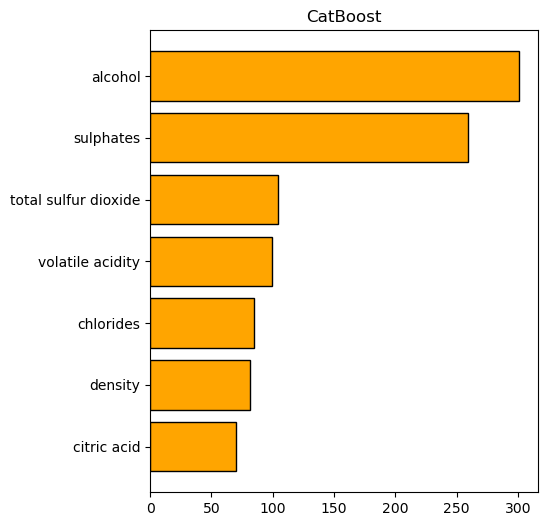

In [23]:
plt.figure(figsize = (5, 6))
cat_imp = np.zeros(len(models[0].feature_importances_))
for model in models[:10]:
    cat_imp += model.feature_importances_
    
plt.barh([features[i] for i in np.argsort(cat_imp)], sorted(cat_imp), 
         color = "orange", edgecolor = "#000000")

plt.title("CatBoost")
plt.show()

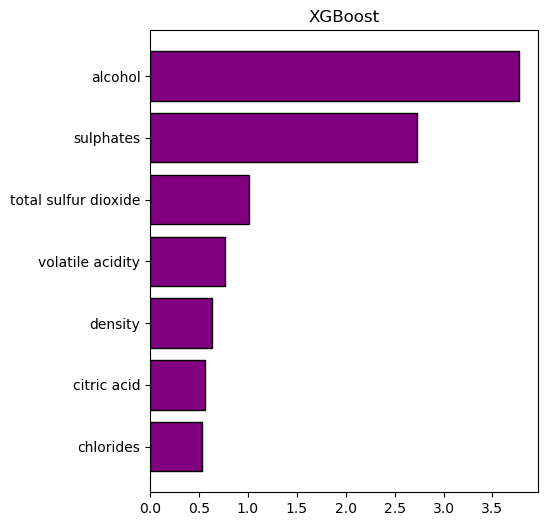

In [24]:
plt.figure(figsize = (5, 6))
xgb_imp = np.zeros(len(models[10].feature_importances_))
for model in models[10:20]:
    xgb_imp += model.feature_importances_
    
plt.barh([features[i] for i in np.argsort(xgb_imp)], sorted(xgb_imp), 
         color = "purple", edgecolor = "#000000")

plt.title("XGBoost")
plt.show()

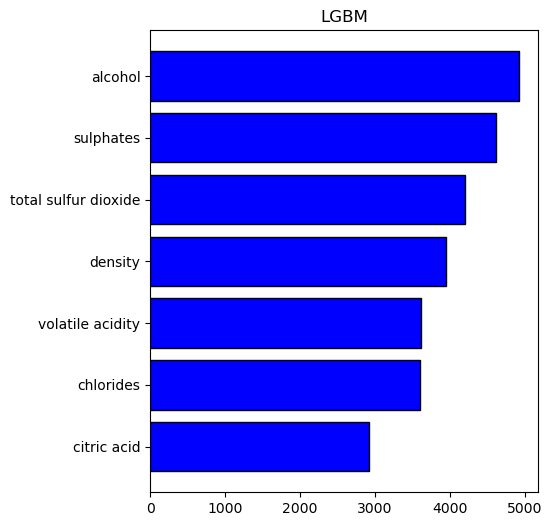

In [25]:
plt.figure(figsize = (5, 6))
lgbm_imp = np.zeros(len(features))
for model in models[20:]:
    lgbm_imp += model.feature_importances_
    
plt.barh([features[i] for i in np.argsort(lgbm_imp)], sorted(lgbm_imp), 
         color = "blue", edgecolor = "#000000")

plt.title("LGBM")
plt.show()

In [26]:
cat_preds = []
xgb_preds = []
lgbm_preds = []

for model in models[:5]:
    preds = model.predict_proba(test[features])[:,1]
    cat_preds.append(preds)
    
for model in models[5:10]:
    preds = model.predict_proba(test[features])[:,1]
    xgb_preds.append(preds)
    
for model in models[10:]:
    preds = model.predict_proba(test[features])[:,1]
    lgbm_preds.append(preds)

In [27]:
cat_preds = np.stack(cat_preds).mean(0)
xgb_preds = np.stack(xgb_preds).mean(0)
lgbm_preds = np.stack(lgbm_preds).mean(0)

In [28]:
cat_df = pd.DataFrame(data = {'id': test.Id, 'Class': cat_preds})
xgb_df = pd.DataFrame(data = {'id': test.Id, 'Class': xgb_preds})
lgbm_df = pd.DataFrame(data = {'id': test.Id, 'Class': lgbm_preds})

print("Cat Correlation with XGB:")
display(cat_df.Class.corr(xgb_df.Class))
print("Cat Correlation with LGBM:")
display(cat_df.Class.corr(lgbm_df.Class))
print("XGB Correlation with LGBM:")
display(xgb_df.Class.corr(lgbm_df.Class))

Cat Correlation with XGB:


0.988278675001155

Cat Correlation with LGBM:


0.8419734668614262

XGB Correlation with LGBM:


0.8229890706952471

# Enssemble

In [29]:
pred_target = [md.predict_proba(test.loc[:,features]) for md in models]

In [30]:
dp = np.zeros(pred_target[0].shape)
row,col = pred_target[0].shape

for pr in range(len(pred_target)):
    for i in range(row):
        for j in range(col):
            if pr > 10:
                dp[i][j] += 0.34*pred_target[pr][i][j]
            else:
                dp[i][j] += 0.33*pred_target[pr][i][j]


In [31]:
blended_preds = [np.argmax(i) for i in dp]# models[4].predict(test.loc[:,features])
# blended_preds = [i[0] for i in models[6].predict(test)]
blended_preds = [i+3 for i in blended_preds]
submission = pd.DataFrame(data = {'Id': test.Id, 'quality': blended_preds})
submission.set_index('Id')
submission.to_csv('blended.csv', index=False)

In [32]:
pd.read_csv('./blended.csv')['quality'].value_counts()

6    650
5    580
7    142
Name: quality, dtype: int64